<a href="https://www.kaggle.com/code/ei0oei/capstone-project1?scriptVersionId=189023883" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Scenario**
The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: what’s likely to make the employee leave the company?

**Goal**
Analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company. 


Step1: Importing required libraries or packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

step2: uploading dataset

In [2]:
#loading dataset
employees_data = pd.read_csv('/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv')
employees_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


step3: Performing EDA

In [3]:
employees_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


This dataset contains 10 columns and 14999 observations. 2 columns have categorical data which we need to change later into numerical data type. This dataset doesn't contain any null values.

In [4]:
employees_data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


umm... There seems to be some issue with last three columns, and some of coulmns names does not follows snake_case... or maybe they needs little altering.

In [5]:
employees_data = employees_data.rename(columns = { 'Work_accident': 'work_accident',
                         'average_montly_hours': 'average_monthly_hours',
                         'Department': 'department',
                         'time_spend_company': 'tenure'})

employees_data.duplicated().sum()

3008

That's a big number (for me :) )... if i drop all will it do any harm to me?

In [6]:
employees = employees_data.drop_duplicates(keep ='first')
employees.duplicated().sum()

0

Great! we have none now... we are almost done with our data exploration,cleaning and transformation. Just needs to check if have any outliners or not.


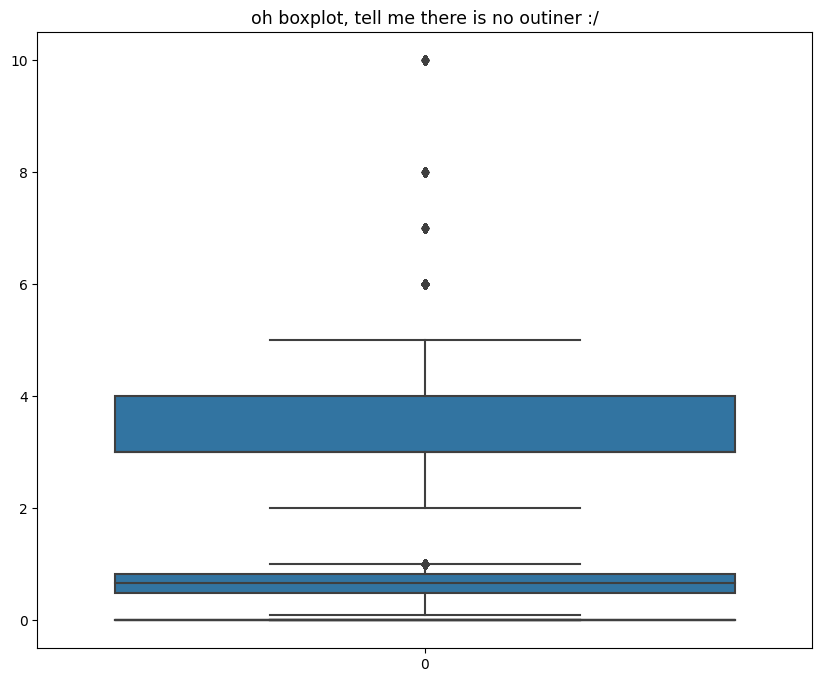

In [7]:
fig, ax = plt.subplots(1, figsize=(10,8))
plt.title('oh boxplot, tell me there is no outiner :/', fontsize = 12.5)
sns.boxplot(employees['tenure'])
sns.boxplot(employees['satisfaction_level'])
sns.boxplot(employees['left'])
sns.boxplot(employees['work_accident'])
sns.boxplot(employees['promotion_last_5years'])
plt.show()

'tenure' seems to have more outliers. 
'left','work_accident', 'promotion_last_5years' seems to have one or few. 
'average_monthly_hours', 'number_project', 'last_evaluation' and 'satisfaction_level' have none.
ig we need to invastigate 'tenure' now...

In [8]:
per25 = employees['tenure'].quantile(0.25)
per75 = employees['tenure'].quantile(0.75)
iqr = per75 - per25
upper_limit = per75 + 1.5*iqr
lower_limit = per25 - 1.5*iqr
print(f'Lower Limit is: {lower_limit} and Upper limit is: {upper_limit}')

outliers = employees[(employees['tenure']>upper_limit)| (employees['tenure']<lower_limit)]
print('outliers exist: ',len(outliers))

Lower Limit is: 1.5 and Upper limit is: 5.5
outliers exist:  824


In [9]:
employees['left'].value_counts(), employees['left'].value_counts(normalize=True)

(left
 0    10000
 1     1991
 Name: count, dtype: int64,
 left
 0    0.833959
 1    0.166041
 Name: proportion, dtype: float64)

step4: data visualization


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

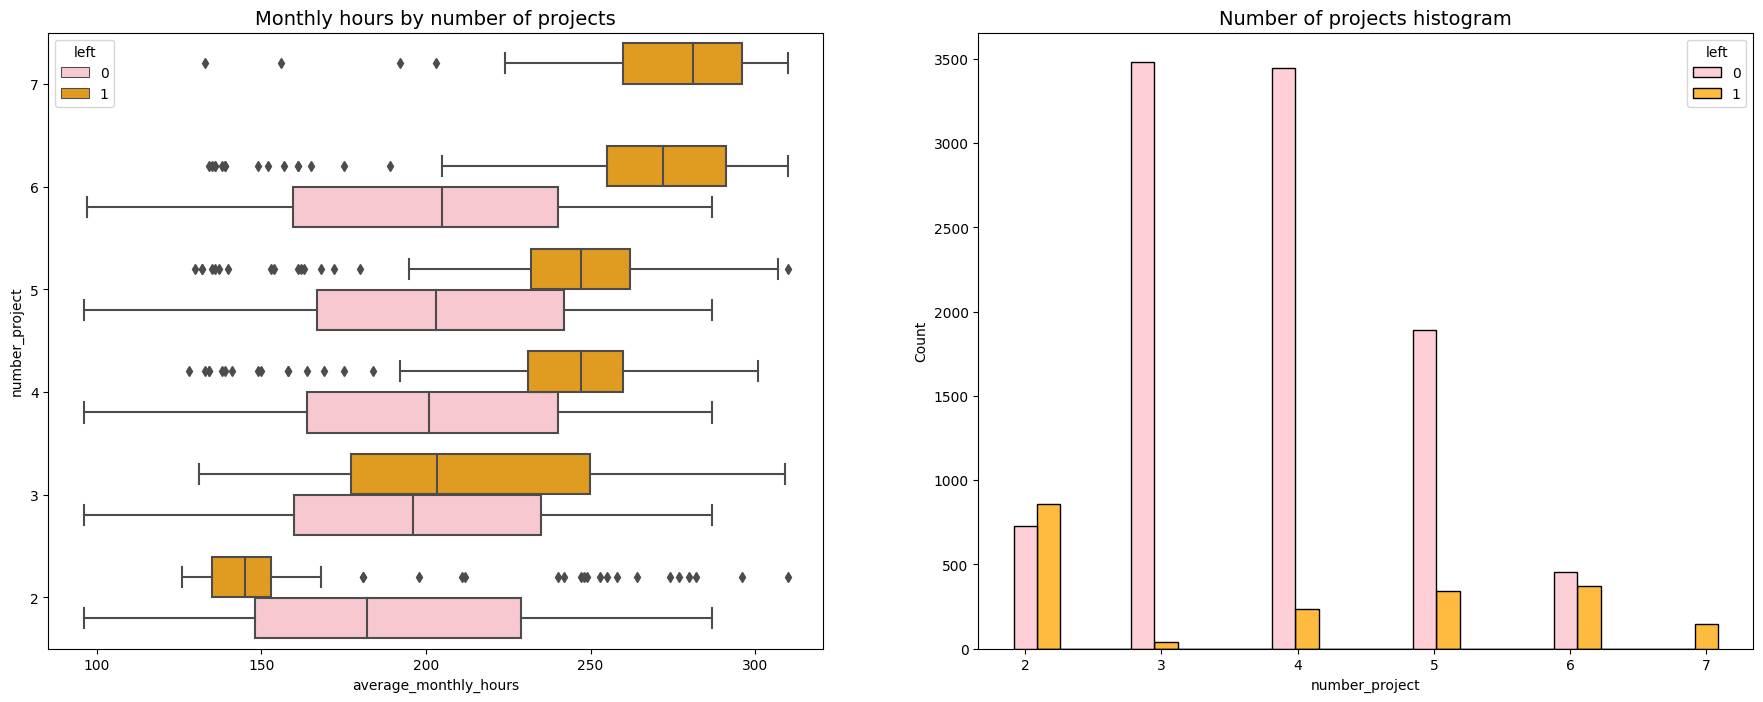

In [10]:
#bOXPLOT
fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=employees, x='average_monthly_hours', y='number_project', hue='left', orient="h",palette=['pink', 'orange'], ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

tenure_stay = employees[employees['left']==0]['number_project']
tenure_left = employees[employees['left']==1]['number_project']
sns.histplot(data=employees, x='number_project', hue='left', multiple='dodge', shrink=2,palette=['pink', 'orange'], ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show()



In [11]:
employees[employees['number_project']==7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

* Two Employee Groups:
Group A (Worked Less/fired): These employees worked considerably less than others with the same number of projects.
Group B (Worked More/voluntarily quit): These employees worked much more than their counterparts.
* All employees with seven projects left the company.
The interquartile ranges for both the seven-six project group  were approximately 255–295 hours per month—significantly higher than other groups.
* Optimal Project Count: around 3–4.
The ratio of employees who left to those who stayed is very small within this range.
Working Hours:
Assuming a 40-hour workweek and two weeks of vacation per year, the average monthly working hours for Monday–Friday employees would be approximately 166.67 hours.
It appears that employees in this dataset are indeed overworked.


we may can do employees survey and ask aout their needs or have open communication with them.

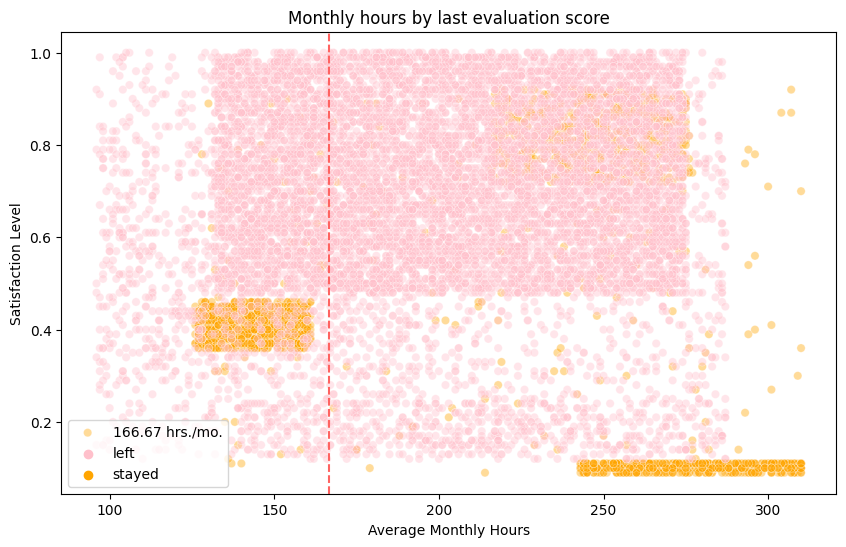

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=employees, x='average_monthly_hours', y='satisfaction_level', hue='left', palette=['pink', 'orange'], alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Satisfaction Level')
plt.show()


* there are some employees having satisfaction level almost 0 working for approx 240 to 340 hours
* some employees with 0.4 satisfaction with normal working hours left too maybe they wanted to job swtich..
* there are alot of empoyyes are satisfy too in every hour 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

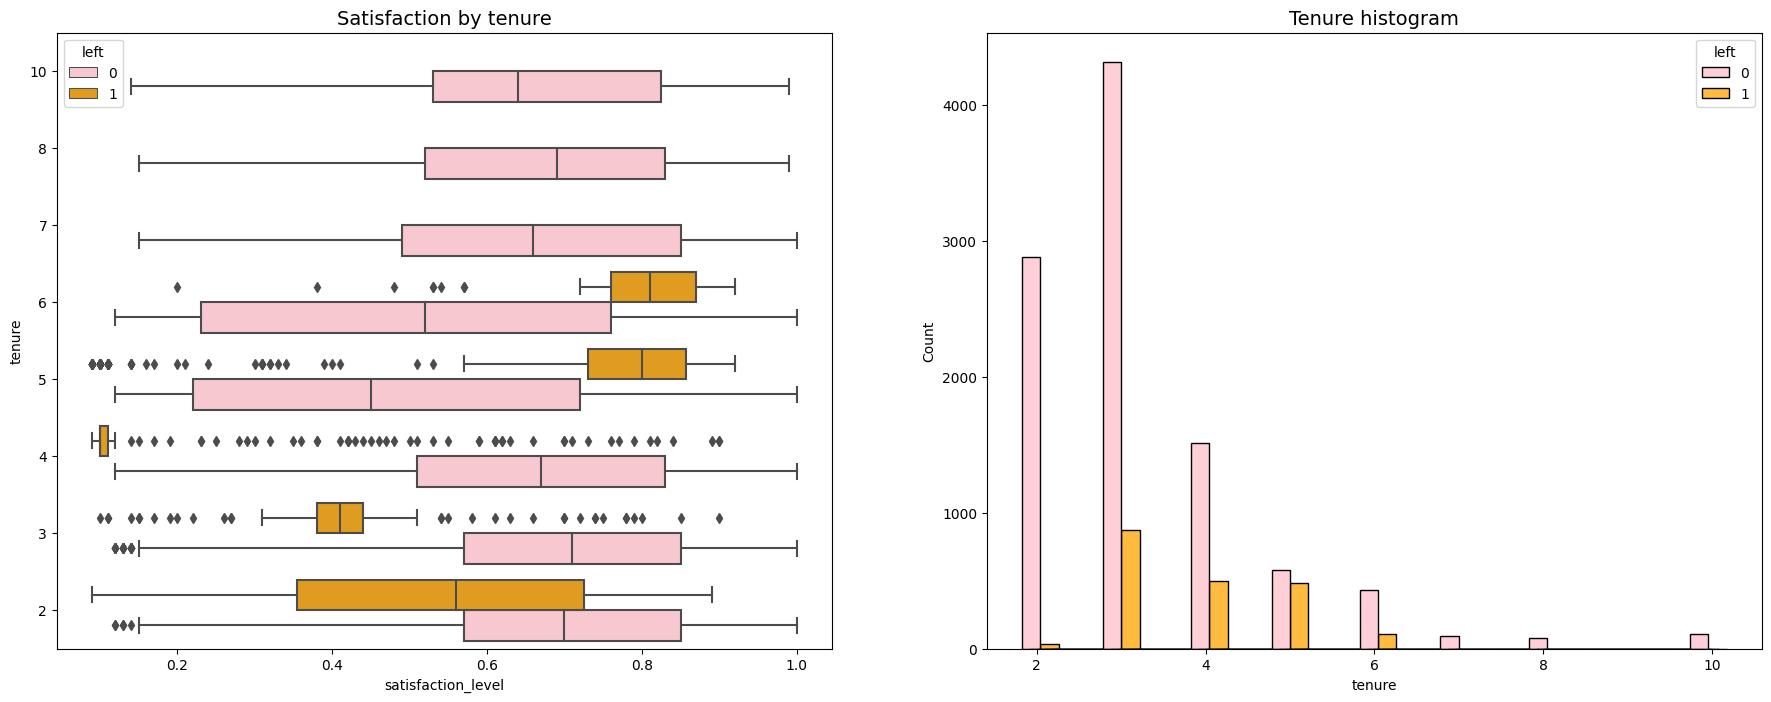

In [13]:
#tenure and satisfaction level
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=employees, x='satisfaction_level', y='tenure', hue='left', orient="h", palette=['pink','orange'],ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# Create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = employees[employees['left']==0]['tenure']
tenure_left = employees[employees['left']==1]['tenure']
sns.histplot(data=employees, x='tenure', hue='left', multiple='dodge', shrink=5,palette=['pink','orange'], ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

* Shortest tenure left more--- 
* long tenure --few
* Dissatisfied employees with shorter tenures.
* satisfied employees with medium-length tenures.
* need to invastigate why 4 year have unusual low satisfaction as its not low tenure.


In [14]:
employees.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

/tmp/ipykernel_19/1492476684.py:1: FutureWarning: The provided callable <function mean at 0x7867cc1f3e20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  employees.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])
/tmp/ipykernel_19/1492476684.py:1: FutureWarning: The provided callable <function median at 0x7867bc36f5b0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  employees.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])


,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


69/41  satisfaction level.... they are both lower than their meadien value

/tmp/ipykernel_19/3978479330.py:6: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1,
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version

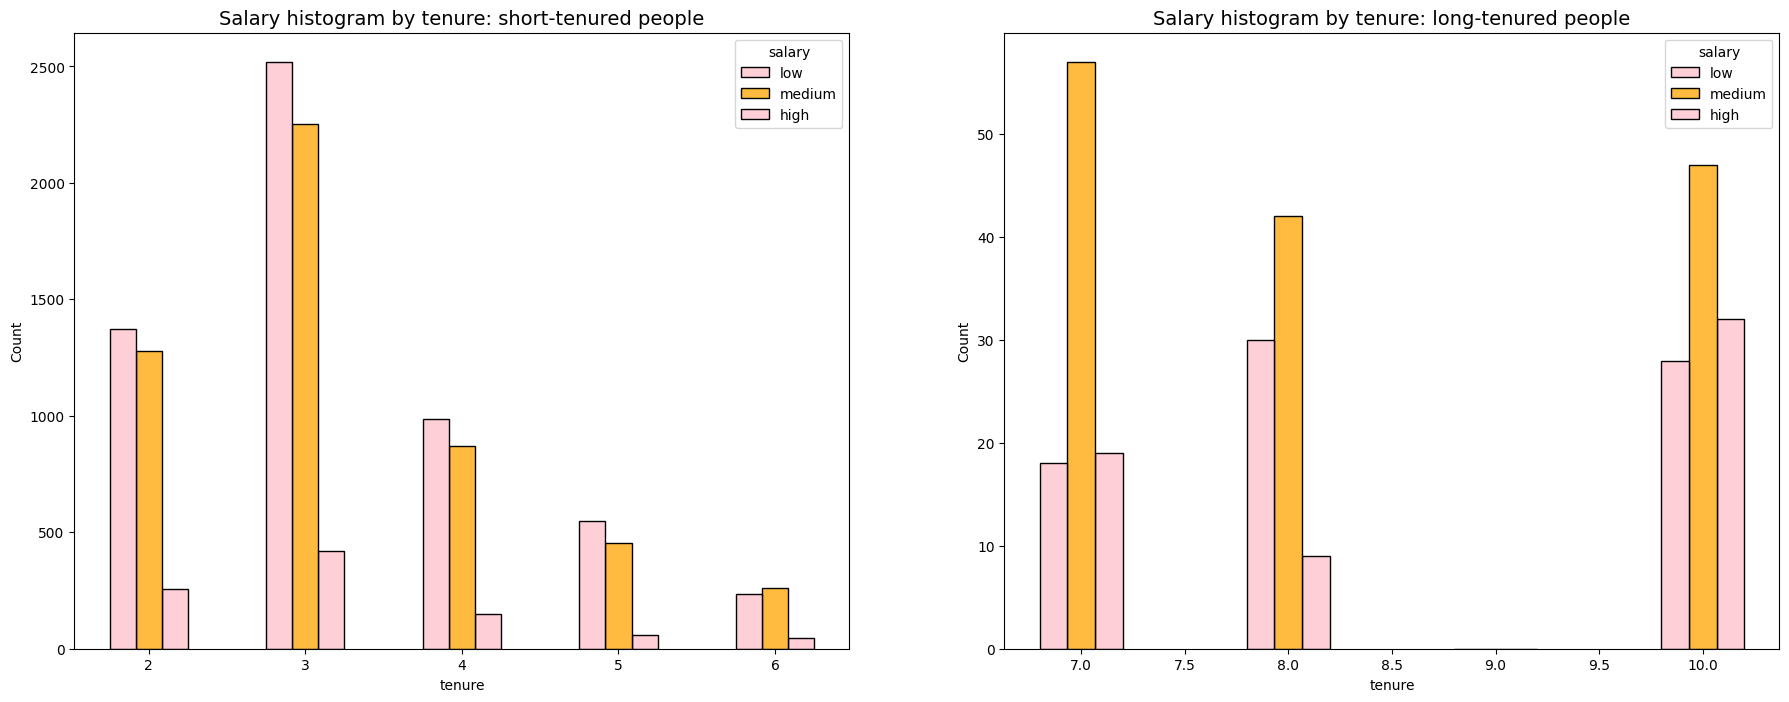

In [15]:
#salary -- tenure
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured employees
tenure_short = employees[employees['tenure'] < 7]
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, palette=['pink','orange'],ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')


# Plot long-tenured histogram
tenure_long = employees[employees['tenure'] > 6]

sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, palette=['pink','orange'],ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

longer tenure did not correlate directly with higher salaries

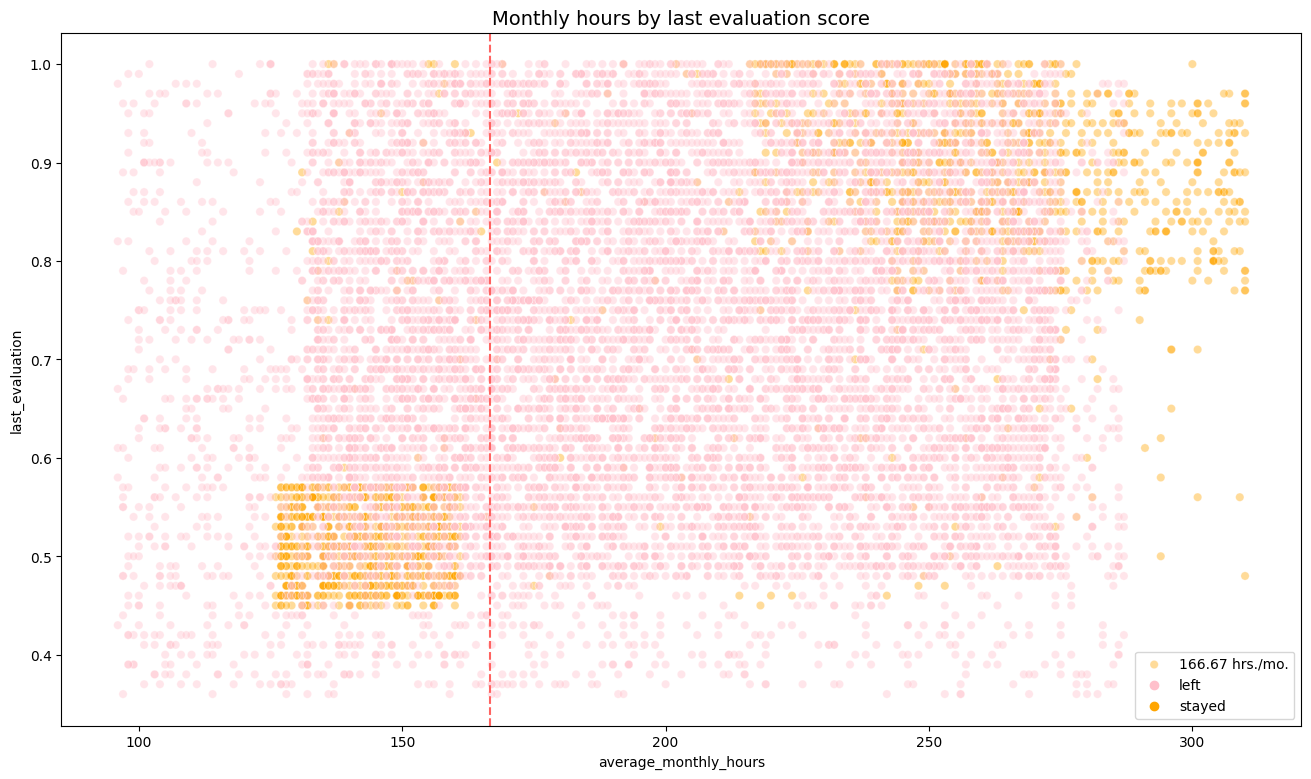

In [16]:
#  scatterplot of `average_monthly_hours` versus `last_evaluation`
plt.figure(figsize=(16, 9))
sns.scatterplot(data=employees, x='average_monthly_hours', y='last_evaluation', hue='left',palette=['pink','orange'], alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

* two groups: over worked one and slightly under worked
* most employees work more than 167 hours
* seems to be a correlation between hours worked and evaluation score

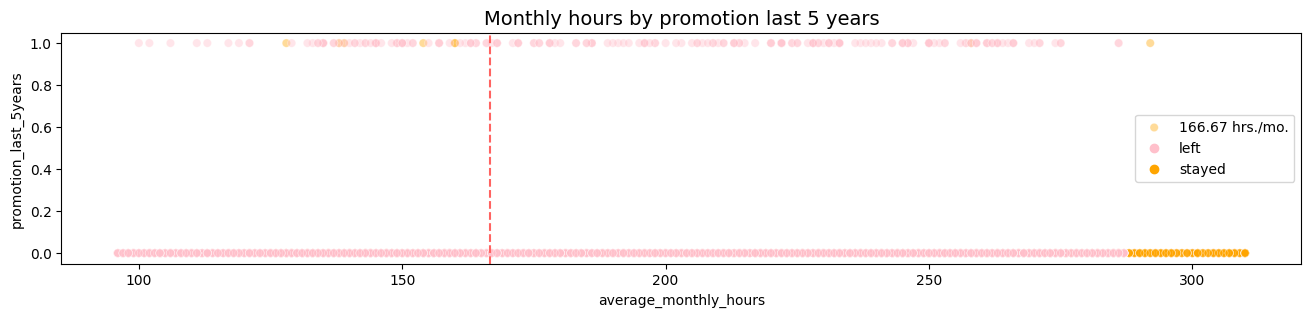

In [17]:
#`average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16, 3))
sns.scatterplot(data=employees, x='average_monthly_hours', y='promotion_last_5years', hue='left', palette=['pink','orange'],alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

* employees eho left were working longest hours
* only few promotions happens

In [18]:
# Display counts for each department
employees["department"].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

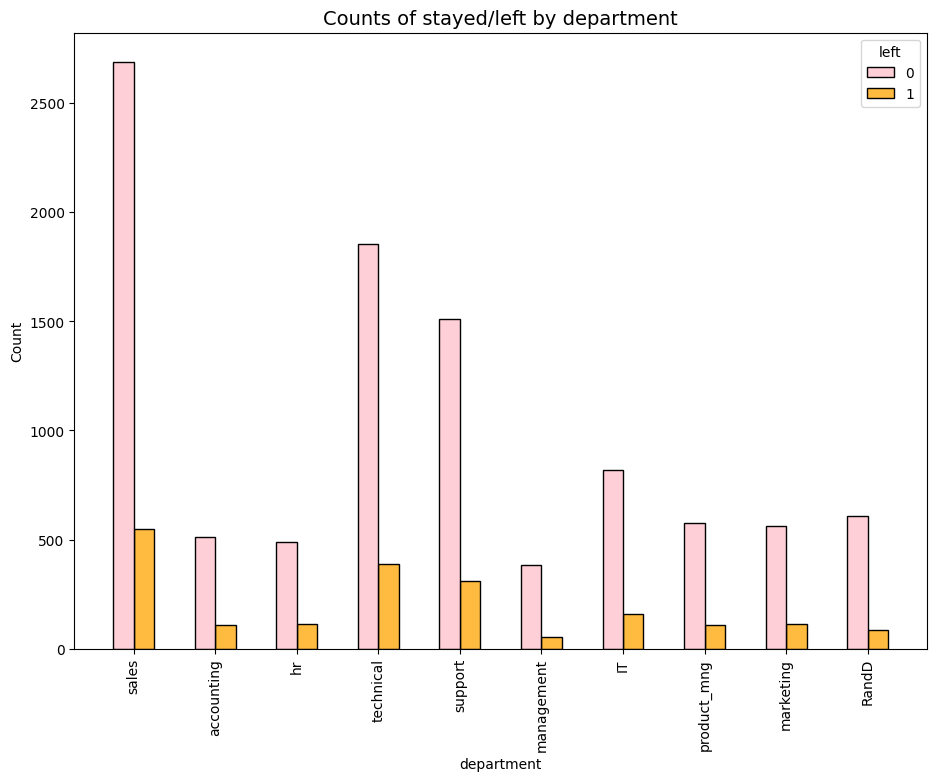

In [19]:
# stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(11,8))
sns.histplot(data=employees, x='department', hue='left',palette=['pink','orange'], discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation='vertical')
plt.title('Counts of stayed/left by department', fontsize=14);


doesn't seems to be much significance of department.

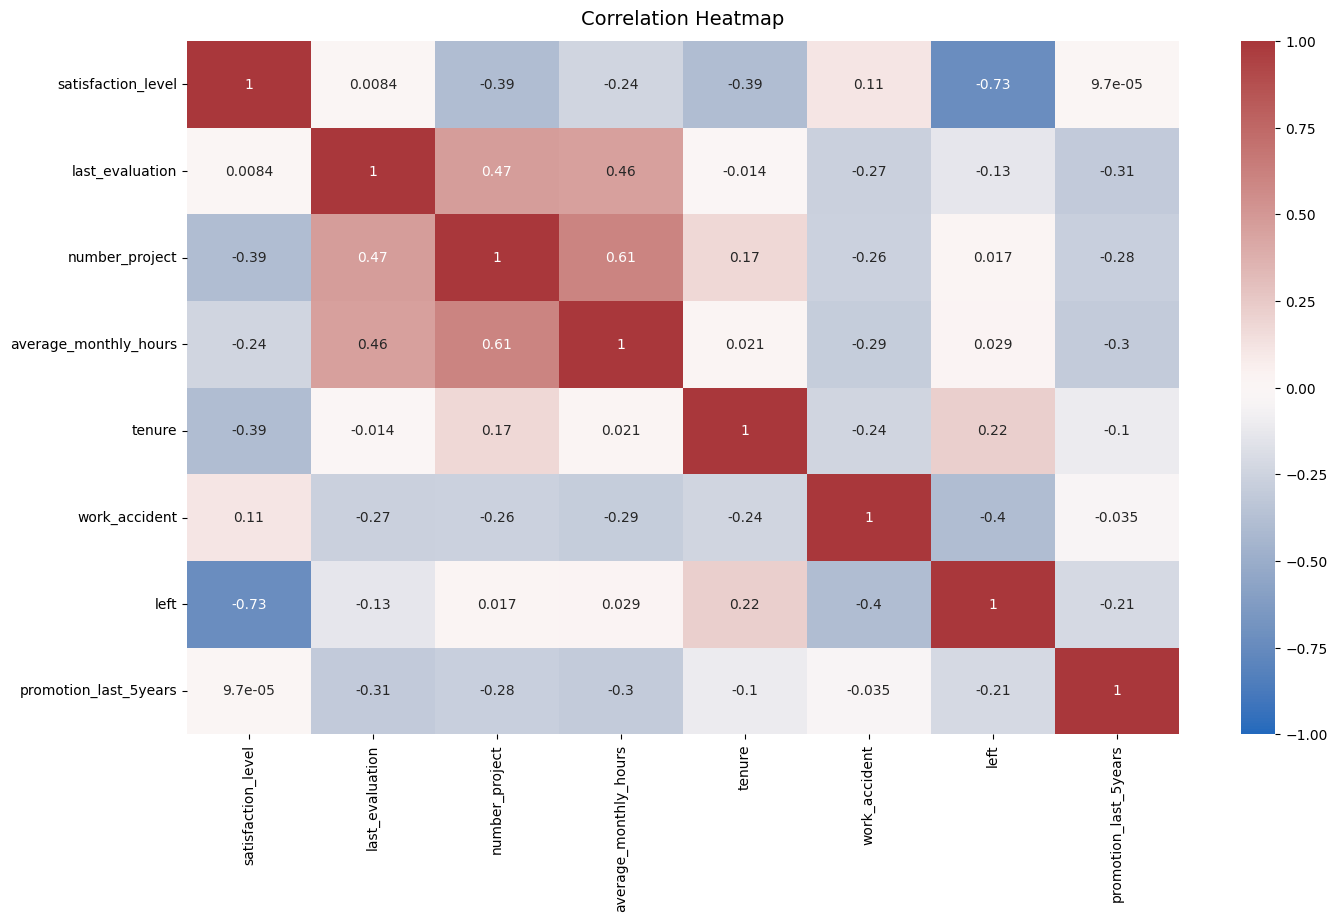

In [20]:

# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
employees_corr = employees_data.drop(columns=['department','salary']).corr()
heatmap = sns.heatmap(employees_corr.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

**INSIGHTS**
It appears that employees are leaving the company as a result of poor management. Leaving is tied to longer working hours, many projects, and generally lower satisfaction levels. It can be ungratifying to work long hours and not receive promotions or good evaluation scores. There's a sizeable group of employees at this company who are probably burned out. It also appears that if an employee has spent more than six years at the company, they tend not to leave.

step5: construct

In [21]:
employees.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours      int64
tenure                     int64
work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object

In [22]:
emp_model = pd.get_dummies(employees, columns=['department','salary'])

In [23]:
y = emp_model['left']
x = emp_model.drop('left', axis = 1)
x_tr, x_test, y_tr, y_test = train_test_split(x, y, stratify=y,test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, stratify=y_tr,test_size=0.25, random_state=42)

In [24]:
for x in [x_train, x_val, x_test]:
    print(len(x))

7194
2398
2399


This align with expectations.

In [25]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300]
             }
#scoring metrics dictionary
scoring = {'accuracy', 'precision', 'recall', 'f1'}

#Instantiate GridSearchCV
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [26]:
%%time
rf_cv.fit(x_train,y_train)

CPU times: user 23 s, sys: 38.1 ms, total: 23.1 s
Wall time: 23.1 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'recall', 'f1', 'precision', 'accuracy'})

In [27]:
 rf_cv.best_score_

0.9096176292339117

In [28]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [29]:
def make_results(model_name:str, model_object, metric:str):
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.980455,0.909618,0.943434,0.981929


The model identifies most of the actual positive instances, though there is a small percentage of positive instances it misses.

In [30]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [31]:
%%time
xgb_cv.fit(x_train, y_train)

CPU times: user 47.3 s, sys: 861 ms, total: 48.2 s
Wall time: 12.7 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'recall', 'f1', 'precision', 'accuracy'})

In [32]:
xgb_cv.best_score_

0.9104481380889319

In [33]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

In [34]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.980455,0.909618,0.943434,0.981929
0,XGB cv,0.963188,0.910448,0.935774,0.979287


* Random Forest (RF cv) outperforms XGBoost (XGB cv) in terms of precision, F1 Score, and accuracy. This means that RF cv has a slightly better overall performance and balances precision and recall more effectively than XGB cv.

In [35]:
# random forest model on validation data
rf_val_preds = rf_cv.best_estimator_.predict(x_val)
rf_val_preds

array([0, 0, 0, ..., 1, 0, 0])

In [36]:
def get_test_scores(model_name:str, preds, y_test_data):
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.980455,0.909618,0.943434,0.981929
0,XGB cv,0.963188,0.910448,0.935774,0.979287
0,RF val,0.973684,0.929648,0.951157,0.984153


Random Forest with Validation Set (RF val) the best performing model overall based on precision, recall, F1 Score, and accuracy. It balances precision and recall well and achieves the highest accuracy.


In [37]:
#  XGBoost model on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(x_val)
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.980455,0.909618,0.943434,0.981929
0,XGB cv,0.963188,0.910448,0.935774,0.979287
0,RF val,0.973684,0.929648,0.951157,0.984153
0,XGB val,0.968085,0.914573,0.940568,0.980817


In [38]:
#  XGBoost model on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(x_test)
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.980455,0.909618,0.943434,0.981929
0,XGB cv,0.963188,0.910448,0.935774,0.979287
0,RF val,0.973684,0.929648,0.951157,0.984153
0,XGB val,0.968085,0.914573,0.940568,0.980817
0,XGB test,0.953488,0.927136,0.940127,0.980409


Based on these metrics, the Random Forest (RF) model in the validation set seems to perform slightly better overall, with high precision, recall, and accuracy.

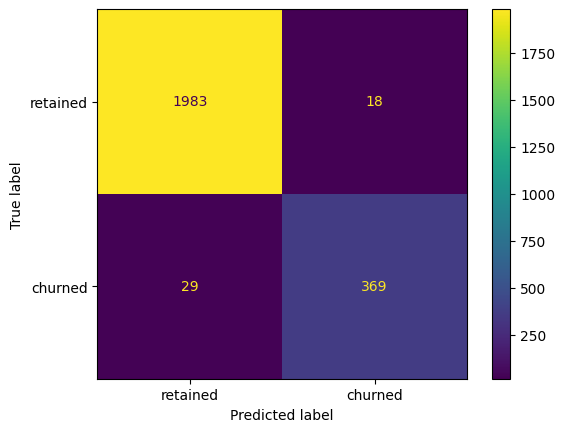

In [39]:

cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

 model performs very well, with high precision, recall, and accuracy, indicating that it is effective at distinguishing between the positive and negative classes.


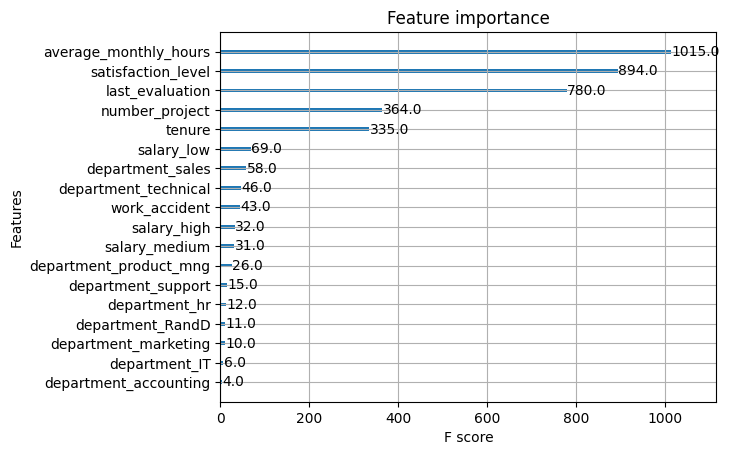

In [40]:
plot_importance(xgb_cv.best_estimator_);

average_monthly_hours, satisfaction_level, last_evaluation, number_project, tenure seems to play important part in employees churn.

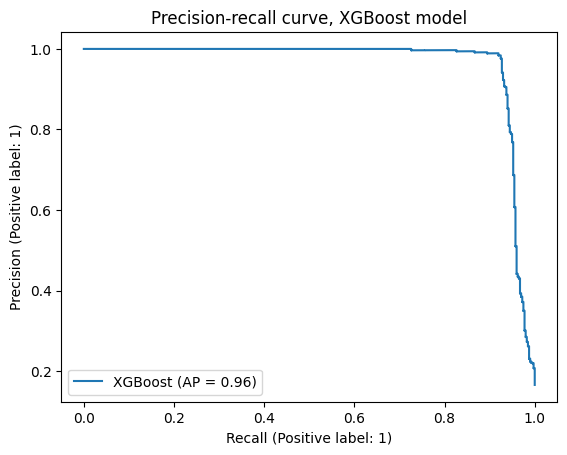

In [41]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(   xgb_cv.best_estimator_, x_test, y_test, name='XGBoost'  )
plt.title('Precision-recall curve, XGBoost model');

AUC is labeled as AP = 0.96, which suggests excellent performance. The model balances precision and recall effectively.


**CONCLUSIONS**

After concluding feature engineering, the model achieved AUC of 96%, precision of 95%, recall of 92%, accuracy of 98%, and F1-score of 94% on the test set. The random forest model outperformed the decision tree model.
The models and the feature importances extracted from the models confirm that employees at the company are overworked.

To retain employees, the following recommendations could be presented to the stakeholders:
- offer perks for working for long hours and encourage employyes to take breaks in between.
- Do survey of working employees and who left to understand employees demands and needs.
- limit the number of projects employees can work.
- Employees worked for longer tenure should be promoting. Company can make policies for promotion criteria.
- Employees who put most efforts for comapny should be rewarded. And who are new needs to be guide properly.
- Can have employees satisfaction surveys atleast once per 6 months or time to time.